In [33]:
import pandas as pd
import numpy as np
import statsmodels.stats.api as sms
import scipy

In [5]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294480 entries, 0 to 294479
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294480 non-null  int64 
 1   timestamp     294480 non-null  object
 2   group         294480 non-null  object
 3   landing_page  294480 non-null  object
 4   converted     294480 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [11]:
df.duplicated().sum()

0

In [12]:
df.nunique()

user_id         290585
timestamp        35993
group                2
landing_page         2
converted            2
dtype: int64

In [19]:
df = df.drop_duplicates(subset = 'user_id', keep = False)
df.shape

(286690, 5)

In [20]:
df.groupby('group')['user_id'].count()

group
control      143293
treatment    143397
Name: user_id, dtype: int64

имеем равные выборки 

Посмотрим на значение целевой метрики

In [23]:
df.groupby('group')['converted'].mean()

group
control      0.120173
treatment    0.118726
Name: converted, dtype: float64

Для t-теста выборки должны соответствовать следующим условиям:
* Равенство дисперсий
* Наблюдения независимы и случайны
* Нормальное распределение средних значений
    

Проверим независимость выборок

In [120]:
sample_user_id_control = []
user_id_control = df.loc[df.group == 'control', 'user_id'].tolist()
user_id_target = df.loc[df.group == 'treatment', 'user_id'].tolist()
print(len(list(set(user_id_control) & set(user_id_target))))

0


Никто из контрольной группы не попал в тестовую и наоборот, значит, выборки независимы.

Проверить случайность мы не можем исходя из данного датасета. Примем это условие на веру.

#### Проверка нормального распределения выборок

H<sub>0</sub> - распределение средних значения 'converted' нормальное  \
H<sub>1</sub> - распределение средних значения 'converted' не соответствует нормальному

Проверим это с помощью бутстрапа, просемплировав выборки

In [27]:
sample_means_control = []
sample_means_target = []
for i in range(10000):
    sample_control = df.loc[df.group =='control', 'converted'].sample(frac=1, replace=True)
    sample_target = df.loc[df.group =='treatment', 'converted'].sample(frac=1, replace=True)
    sample_means_control.append(sample_control.mean())
    sample_means_target.append(sample_target.mean())

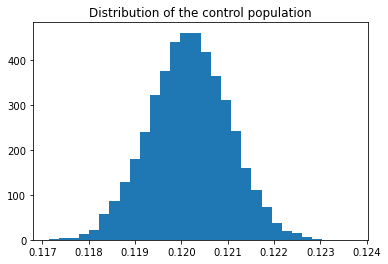

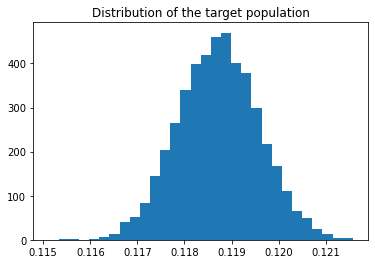

In [51]:
import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(sample_means_control, 30, density = True)
plt.title('Distribution of the control population')
plt.show()
count, bins, ignored = plt.hist(sample_means_target, 30, density = True)
plt.title('Distribution of the target population')
plt.show()

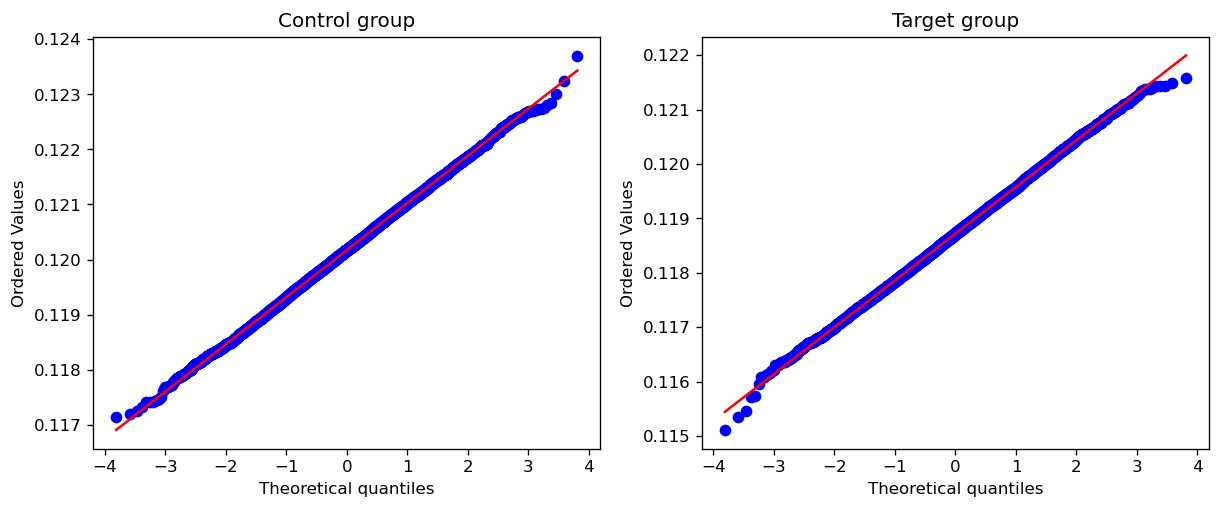

In [41]:
plt.figure(figsize=(12,10), dpi = 120)
plt.subplot(2,2,1)
scipy.stats.probplot(sample_means_control, dist="norm", plot=plt)
plt.title('Control group')
plt.subplot(2,2,2)
scipy.stats.probplot(sample_means_target, dist="norm", plot=plt)
plt.title('Target group')
plt.show()

In [68]:
sp_shapiro_control = scipy.stats.shapiro(sample_means_control)
concl_shapiro_control = '=> не стат значимо, нормальное' if sp_shapiro_control[1]>0.05 else '=> стат значимо не нормально' 
print('Тест на нормальность распределения control группы: W = %.3f' % sp_shapiro_control[0],',\np-value = %.3f' % sp[1], concl_shapiro_control)

sp_shapiro_target = scipy.stats.shapiro(sample_means_target)
concl_shapiro_target = '=> не стат значимо, нормальное' if sp_shapiro_target[1]>0.05 else '=> стат значимо не нормально' 
print('Тест на нормальность распределения target группы: W = %.3f' % sp_shapiro_target[0],',\np-value = %.3f' % sp[1], concl_shapiro_target)


Тест на нормальность распределения control группы: W = 1.000 ,
p-value = 0.158 => не стат значимо, нормальное
Тест на нормальность распределения target группы: W = 1.000 ,
p-value = 0.158 => не стат значимо, нормальное


D:\Anaconda\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#### Проверка гомогенности дисперсий выборок

Проверим с помощью критерия Левена

In [59]:
import seaborn as sns

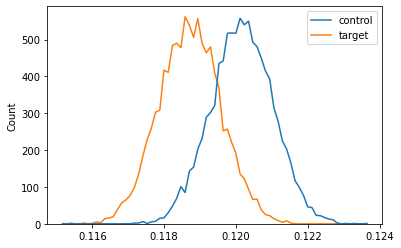

In [58]:
control_target_samples = {'control': sample_means_control, 'target': sample_means_target}
var_data = pd.DataFrame(control_target_samples)
sns.histplot(data=var_data, element="poly", color='r', fill=False);


In [71]:
sp_levene = scipy.stats.levene(sample_means_control, sample_means_target, center = 'mean')
concl_levene = '=> не стат значимо, гомогенны' if sp_levene[1]>0.05 else '=> стат значимо не гомогенно' 
print('Тест на гомогенность дисперсий групп: W = %.3f' % sp_levene[0],',\np-value = %.3f' % sp_levene[1], concl_levene)


Тест на гомогенность дисперсий групп: W = 0.177 ,
p-value = 0.674 => не стат значимо, гомогенны


#### Выборки удовлетворяют всем требованиям для применения t-теста. 

H<sub>0</sub> - Средние значения совокупностей равны  \
H<sub>1</sub> - Средние значения совокупностей отличны

In [78]:
sp_t_test = scipy.stats.ttest_ind(a=sample_means_control, b=sample_means_target, equal_var=True)
concl_t_test = '=> не стат значимо, Средние значения совокупностей равны' if sp_t_test[1]>0.05 else '=> стат значимо, cредние значения совокупностей отличны' 
print('Тест на равентво средних значений контрольной и тестовой групп: W = %.3f' % sp_t_test[0],'\np-value = %.6f' % sp_t_test[1], concl_t_test)

Тест на равентво средних значений контрольной и тестовой групп: W = 119.467 
p-value = 0.000000 => стат значимо, cредние значения совокупностей отличны


In [87]:
percent_diff = (var_data.control.mean() - var_data.target.mean())/var_data.target.mean() * 100
print(f'Новый дизайн сайта увеличил конверсию на {np.round(percent_diff, 2)}%')

Новый дизайн сайта увеличил конверсию на 1.22%


### В итоге, изменение дизайна страницы сайта статистически значимо повлияло на увеличение показателя метрики conveted на 1.22%